# 1. Importing libraries & options

In [1]:
import os
#os.environ['TF_LIBRARY_PATH'] = 'C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/nvvm/libdevice/libdevice.10.bc'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import numpy as np
import pandas as pd

from keras.layers import Conv2D, MaxPool2D, Dropout, \
Dense, Input, GlobalAveragePooling2D, AveragePooling2D

import regex as re
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# 2. Reading data

In [3]:
# Extracting the name of the folders
folders = [name[0] for i,name in enumerate(os.walk('../data/train')) if i !=0]
#folders

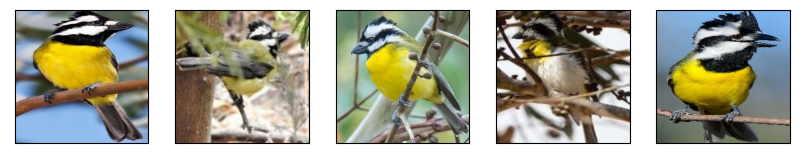

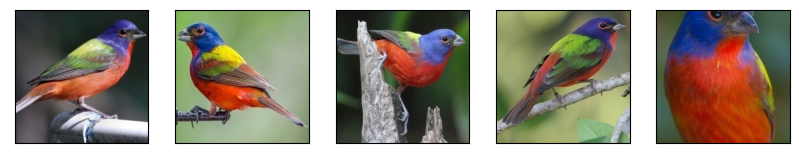

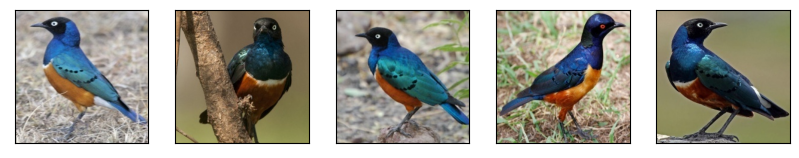

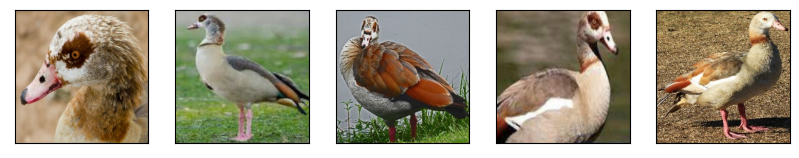

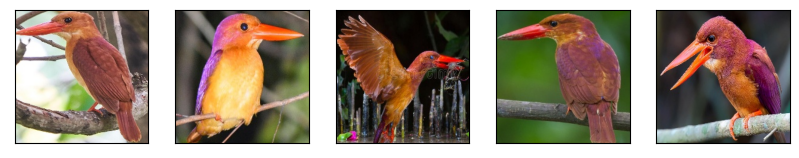

In [33]:
# Reading images
images_list = []
series = 0
for folder in folders[115:]:
    
    # reading the name of the animal
    animal_class = folder[0].replace('../data/train/','').lower().replace(' ','_')
    
    # reading all the images
    images = [name for name in os.walk(folder)][0][2]
    
    # --> looping for every image in the folder

    count = 0
    fig, ax = plt.subplots(1, 5,figsize=(10,10))
    for i,image in enumerate(images):
        image = Image.open(folder+'/'+image)
        ax[i-1].imshow(image)
        ax[i-1].set_xticks([])
        ax[i-1].set_yticks([])
        count += 1
        if count == 5:
            break
        
    plt.show()
    series += 1
    if series == 5:
        break

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,  # rescale the pixel values to [0, 1]
    zoom_range=0.2,  # apply random zooming
    horizontal_flip=True  # randomly flip the images horizontally
)

train_generator = train_datagen.flow_from_directory(
    directory='../data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    directory='../data/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# 3. Inception network

In [ ]:
from keras.layers import Conv2D, MaxPool2D, Dropout, \
Dense, Input, GlobalAveragePooling2D, AveragePooling2D


In [ ]:
def inception_module(input_,filters_1x1,filters_3x3_pre, filters_3x3, filters_5x5_pre, filters_5x5, filters_maxpool, name = None):
    
    # Inception block
    conv_1x1 = Conv2D(filters_1x1, 1, strides=(1, 1), padding='same', activation='relu', 
                      kernel_initializer=tf.keras.initializers.glorot_uniform(),
                      bias_initializer=bias_initializer)(input_)
    
    conv_3x3 = Conv2D(filters_3x3_pre, 1, strides=(1, 1), padding='same', activation='relu', 
                      kernel_initializer=tf.keras.initializers.glorot_uniform(),
                      bias_initializer=bias_initializer)(input_)
    conv_3x3 = Conv2D(filters_3x3, 3, strides=(1, 1), padding='same', activation='relu', 
                      kernel_initializer=tf.keras.initializers.glorot_uniform(),
                      bias_initializer=bias_initializer)(conv_3x3)
    
    conv_5x5 = Conv2D(filters_5x5_pre, 1, strides=(1, 1), padding='same', activation='relu',
                      kernel_initializer=tf.keras.initializers.glorot_uniform(),
                      bias_initializer=bias_initializer)(input_)
    conv_5x5 = Conv2D(filters_5x5, 3, strides=(1, 1), padding='same', activation='relu',
                      kernel_initializer=tf.keras.initializers.glorot_uniform(),
                      bias_initializer=bias_initializer)(conv_5x5)
    
    max_pool = MaxPool2D(pool_size=(3, 3),strides=(1,1),padding='same')(input_)
    max_pool = Conv2D(filters_maxpool, 1, strides=(1, 1), padding='same', activation='relu',
                      kernel_initializer=tf.keras.initializers.glorot_uniform(),
                      bias_initializer=bias_initializer)(max_pool)

    output =  tf.keras.layers.concatenate([conv_1x1, conv_3x3, conv_5x5, max_pool], axis=3, name=name)
    return output

In [ ]:
# Initializers
bias_initializer = tf.keras.initializers.Constant(value=0.)


In [ ]:
# Neural Network

n_categories = 510
input_layer =  Input(shape=(224,224,3))



# BLOCK - 1
x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7', 
           kernel_initializer=tf.keras.initializers.glorot_uniform(), bias_initializer=bias_initializer)(input_layer)

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3')(x)
#x = tf.nn.local_response_normalization(x, name ='norm1')



# BLOCK - 2
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_1x1', 
           kernel_initializer=tf.keras.initializers.glorot_uniform(), bias_initializer=bias_initializer)(x)

x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3', 
           kernel_initializer=tf.keras.initializers.glorot_uniform(), bias_initializer=bias_initializer)(x)

#x = tf.nn.local_response_normalization(x, name ='norm2')
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3')(x)



# BLOCK - 3 (Inception modules)
x = inception_module(x, filters_1x1=64, filters_3x3_pre=96, filters_3x3=128, filters_5x5_pre=16,
                     filters_5x5=32, filters_maxpool=32, name='inception_3a')
x = inception_module(x, filters_1x1=128, filters_3x3_pre=128, filters_3x3=192, filters_5x5_pre=32,
                     filters_5x5=96, filters_maxpool=64, name='inception_3b')
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3')(x)



# BLOCK - 4
x = inception_module(x, filters_1x1=192, filters_3x3_pre=96, filters_3x3=208, filters_5x5_pre=16,
                     filters_5x5=48, filters_maxpool=64, name='inception_4a')

# ---> auxilliary output 1 
x1 = AveragePooling2D((5, 5), strides=3, padding='valid')(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = tf.keras.layers.Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(n_categories, activation='softmax', name='auxilliary_output_1')(x1)
# --->

x = inception_module(x, filters_1x1=160, filters_3x3_pre=112, filters_3x3=224, filters_5x5_pre=24,
                     filters_5x5=64, filters_maxpool=64, name='inception_4b')
x = inception_module(x, filters_1x1=128, filters_3x3_pre=128, filters_3x3=256, filters_5x5_pre=24,
                     filters_5x5=64, filters_maxpool=64, name='inception_4c')
x = inception_module(x, filters_1x1=112, filters_3x3_pre=144, filters_3x3=288, filters_5x5_pre=32,
                     filters_5x5=64, filters_maxpool=64, name='inception_4d')

# ---> auxilliary output 2
x2 = AveragePooling2D((5, 5), strides=3, padding='valid')(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = tf.keras.layers.Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(n_categories, activation='softmax', name='auxilliary_output_2')(x2)
# --->

x = inception_module(x, filters_1x1=256, filters_3x3_pre=160, filters_3x3=320, filters_5x5_pre=32,
                     filters_5x5=128, filters_maxpool=128, name='inception_4e')
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3')(x)



# BLOCK - 5
x = inception_module(x, filters_1x1=256, filters_3x3_pre=160, filters_3x3=320, filters_5x5_pre=32,
                     filters_5x5=128, filters_maxpool=128, name='inception_5a')
x = inception_module(x, filters_1x1=384, filters_3x3_pre=192, filters_3x3=384, filters_5x5_pre=48,
                     filters_5x5=128, filters_maxpool=128, name='inception_5b')
x = GlobalAveragePooling2D(name='avg_pool_5_3x3')(x)
x = Dropout(0.4)(x)
x = Dense(n_categories, activation='softmax', name='output')(x)



model =  tf.keras.Model(input_layer, [x, x1, x2], name='inception_v1')

## 3.1 Saving checkpoints of the models while training.

In [ ]:
#Include the epoch in the file name (uses `str.format`)
checkpoint_path = "train_cp/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

epotch_size = 2561

# Create a callback that saves the model's weights every 1 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=epotch_size)

## 3.2 Training the model
The real training will be performed running a train.py file since jupyter notebook is not recommended for intensive training.

In [ ]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'],
              loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, epochs=50, validation_data = val_generator, callbacks=[cp_callback])

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()